### By Yada Pruksachatkun 

This video has been really useful:
https://www.youtube.com/watch?v=lsKIhNkzpbw
Notes from this week

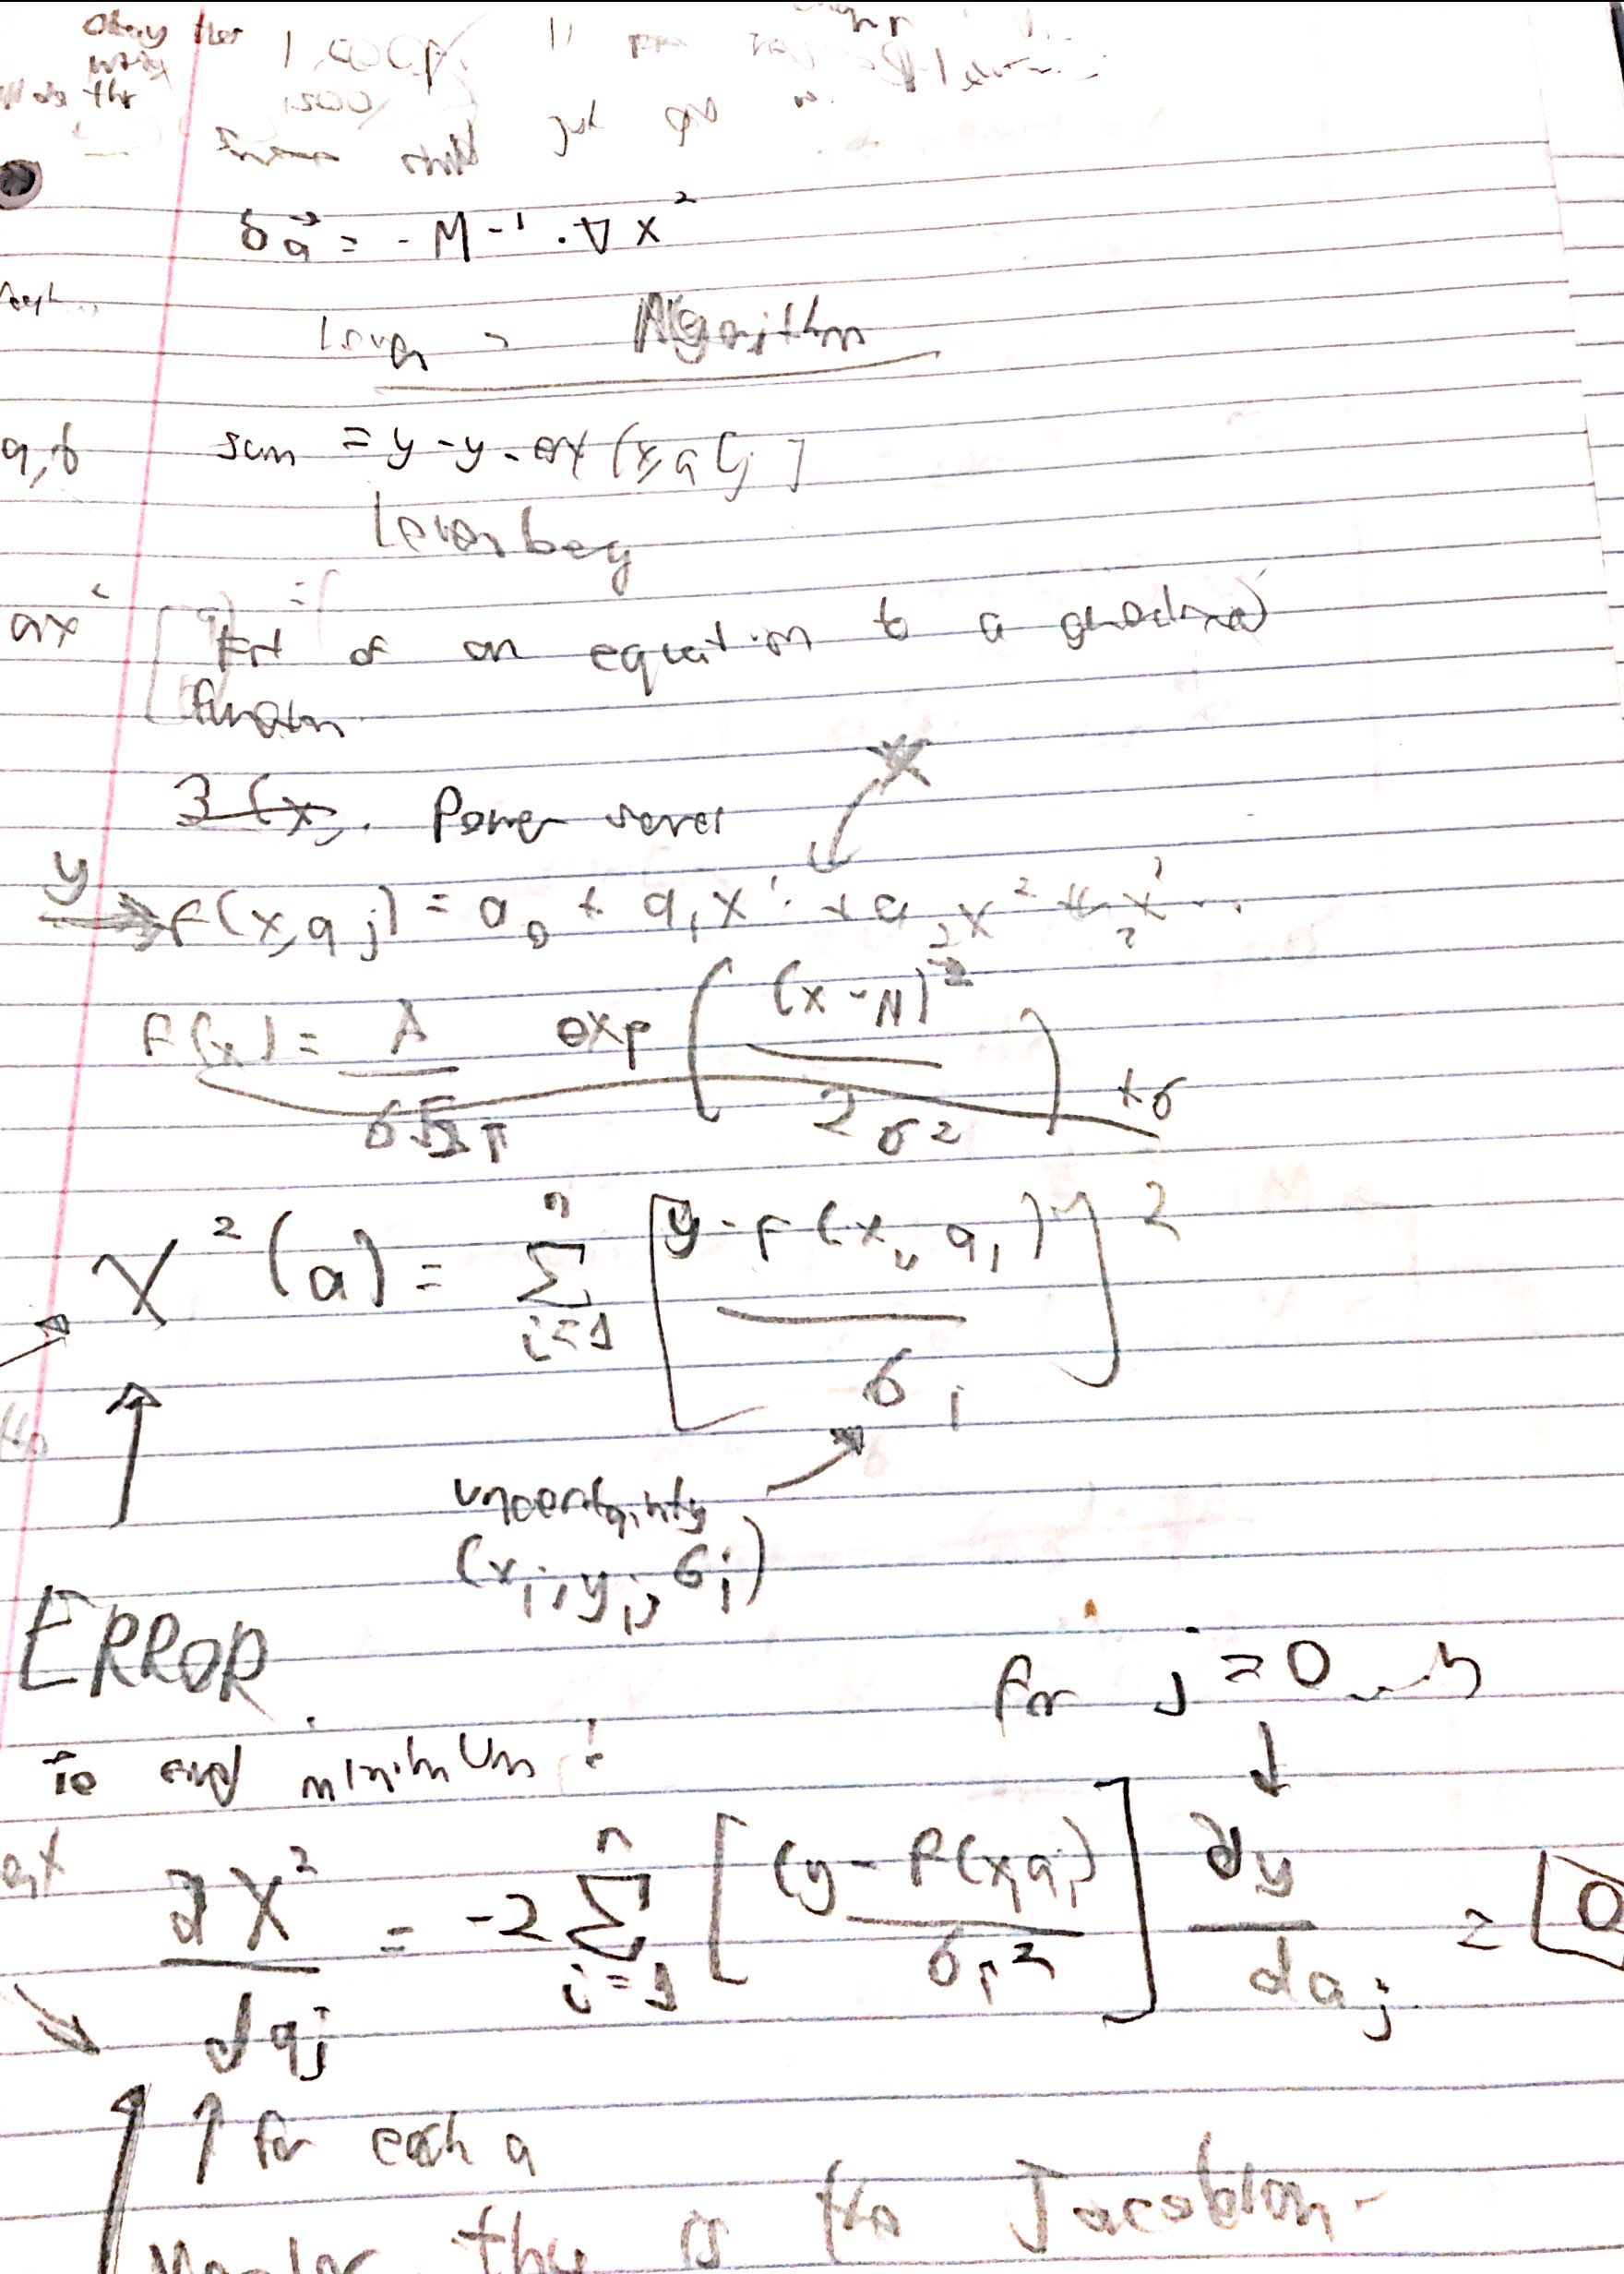

In [2]:
from IPython.display import Image
from IPython.display import FileLink, FileLinks
Image(filename='files/notes_wk7.jpg')

Generate 100 points x uniformly distributed between 0 and 1, and let y = 2+3x+ζ,
where ζ is a Gaussian random variable with a standard deviation of 0.5. Use an
SVD to fit y = a + bx to this data set, finding a and b. Evaluate the errors in a
and b

In [1]:
import numpy as np
import random


def generate_datasets(eq):
	x = np.random.random_sample(size=100)
	vfunc = np.vectorize(eq)
	y = vfunc(x)
	return x,y

def one_over(w):
	out = np.zeros(len(w))
	for i in range(len(w)):
		if w[i] == 0:
			out[i] = 0
		else:
			out[i] = 1/w[i]
	return out
# ewhat is this?IDK

def generate_A(x):
	L=np.empty([100,2])
	A = L.copy()
	for i in range(100):
	    A[i,1]=x[i]
	    A[i,0]=1
	A = np.matrix(A)
	return A

def generate_svd(A, N, M, y):
	# Given a y, and an transformaiton a, what is the x?
	# Here, you want to find the betas that will transform x into y
	# finding the egienvector ot the transformation matrix 
	# to get the exact parameters for the fitting model.
	U, w_origin, V = np.linalg.svd(A)
	w = np.matrix(np.append(np.diag(one_over(w_origin)), np.zeros([M, N-M]),1))
	y = np.matrix(y).T
	x= V.T*w*U.T*y 
	return x, w_origin, U, V

def problem_one(x, y):
	N = 100
	M = 2
	A = generate_A(x)
	x_svd, w_origin, U, V = generate_svd(A, N, M, y)
	print("a = ") # These are the parameters.
	print(x_svd[0,0])
	print("b =")
	print(x_svd[1, 0])
	error_a = 0
	error_b = 0
	for i in range(len(V)):
		error_a += (np.asarray(V)[0,i]**2)/(np.asarray(w_origin)[0]**2)
		error_b += (np.asarray(V)[1,i]**2)/(np.asarray(w_origin)[1]**2)
	error_a = pow(0.25*error_a, 0.5) 
	error_b = pow(0.25*error_b, 0.5) # 0.25 = 0.5^2
	print("12.34")
	print("error for a")
	print(error_a)
	print("error for b")
	print(error_b)
	print("Bootstrap sampling")
	# If we didn't have an error model, we looka t teh observatiosn y  to see the error 
	# in the data
	#Here, resample y becasue that is the output. 
	strap_x = [x[np.floor(np.random.rand(100)*len(x)).astype(int)] for i in range(100)]
	strap_y = [np.array(y)[np.floor(np.random.rand(100)*len(y)).astype(int)] for i in range(100)]
	# now for each x and y, you want to fit it and get back the x and y, and find the 
	# mean and std of that. 
	resample_a =[]
	resample_b = []
	for i in range(100):
		A = generate_A(strap_x[i])
		x_svd, w_origin, U, V = generate_svd(A, N, M, strap_y[i])
		resample_a.append(x_svd[0,0])
		resample_b.append(x_svd[1,0])
	mean_a = np.mean(resample_a)
	std_a = np.std(resample_a)
	mean_b = np.mean(resample_b)
	std_b = np.std(resample_b)
	print("For a")
	print("By bootstrapping, the mean is")
	print(mean_a)
	print("The standard deviation is")
	print(std_a)
	print("For b")
	print("By bootstrapping, the mean is")
	print(mean_b)
	print("The standard deviation is")
	print(std_b)

	# Independent sampling is similar to bootstrap except you generate 
	# the x and y randomly each time before ou fit and lok at the mean
	# and standard deviation 

"""
Error metric - can be statistical or model-based based on the data points. 
Levensten algorithm solves the following:
 Nonlinear Least Squares Minimization
 Jacobian - d(x,y)/d(u,v) 
[ dx/du.    dx/dv 
   dy/du    dy/dv ]
  Hessian matrix - 
  [ d^2f/dxx  d^2f/dxdy 
  	d^2f/dydx	d^2f/dyy]
  	Notes:
  	To calculate the con
  	Intuition: 
  	The Levenberg algorithm is able to know by how much you should go down 
  	iteratively and when to swithc between the Gauss and Newton by usingthe curvature

  	How this algorithm works:
  	The intiial function 
  	a_new = a_old - STEP* deriv(X^2)
  	To get STEP, compute the Hessian, Jacobian, etc. and do levensten 
  	Plug in and calculate X^2 and see if it improves. 
    If the step improves the error, λ is decreased (Newton’s method is best near a minimum),
    and if the step increases the error then λ is increased (gradient descent is better).
    Here, do incremental changes in lambda. 
    The lambda in teh function switches the equaiton from gradient to 
    Newton.

 """

def gen_jacob(x,a):
	j = zeros(2)
	j[0] = cos(a[0]*x+a[1])
	j[1] = x*cos(a[0]*x+a[1])
	return j

def calculate_M(x, a, stepsize):
	h = zeros([2,2])
	h[0][0] = -sin(a[0]*x+a[1]) * (1+ stepsize)
	h[1][0] = -x*sin(a[0]*x+a[1])
	h[0][1] = -x*sin(a[0]*x+a[1])
	h[1][1] = -x**2*sin(a[0]*x+a[1])* (1+ stepsize)
	return (1/2)*h

def gen_chi_error(a, y, eq, std, j):
	def eq_to_fit(x, a):
		 return np.sin(a+(b*x))
	return sum( ((y-eq_to_fit(x, a[j]))**2)/std) # standard dev of the data

def gen_deriv_chi(x, y, a):
	def eq_to_fit(x, a):
		 return np.sin(a+(b*x))
	del_chisq = -2*sum((y-eq_to_fit(x,a[j]))/((eq_to_fit(x,a[j])-y)**2)*gen_jacob(x,a))
	return del_chisq

def param_update(curr_a, x,y, stepsize ):
	M = calculate_M(x, curr_a, stepsize)
	delta_chi = generate_deriv_chi(x, y,curr_a)
	delta_a = -1*np.inverse(M) * delta_chi
	return delta_a

def converge(prev_chi, next_chi, stepsize, lambda_improve, lambda_worsened):
	if (abs(next_chi - prev_chi) < 0.00001): 
		return None
	elif (next_chi < prev_chi):
		return lambda_improve(stepsize)
	elif (prev_chi < next_chi):
		return lambda_worsened(stepsize)

def levenberg():
	eta = random.gauss(mu=0.5,sigma=0.1)
	eq = lambda t : np.sin(2 + (3*t))+ eta
	x, y = generate_datasets(eq)
	curr_a = np.array([1,1]) # seed = 1, 1
	stepsize = 10 # big 
	for i in range(100):
		prev_chi = gen_chi_error(x,y, curr_a, 0.1)
		delta_a = param_update(prev_a,x, y, stepsize)
		curr_a = curr_a + delta_a  # update step
		curr_chi = gen_chi_error(x,y, curr_a, 0.1)
		stepsize = converge(prev_chi, curr_chi)
		yprime = []
		if (stepsize) == False:
			for i in range(len(x)-converged):
				yprime.append(np.sin(a*x[i]+b))
	return yprime # These are the estimated points of the form y = ax+b


eta = random.gauss(mu=0.5,sigma=0.5)
eq = lambda t: 2+(3*t)+eta
x, y = generate_datasets(eq)
x_fin = np.reshape(x, (-1, 1))
y_fin =y.tolist()
problem_one(x_fin,y_fin)
levenberg()



a = 
2.44711510935
b =
3.0
12.34
error for a
0.0449174496075
error for b
0.198371989529
Bootstrap sampling
For a
By bootstrapping, the mean is
3.88074836232
The standard deviation is
0.149673454706
For b
By bootstrapping, the mean is
-0.0116081508185
The standard deviation is
0.25811347839


TypeError: gen_chi_error() missing 1 required positional argument: 'j'